In [2]:
# imports

import h5py
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import itertools
from pathlib import Path
import torch
import json

from utils import (
    extract_diagonals,
    fold_OP_mat,
    matrix_processing,
    plot_complex_matrix,
    get_interpolated_matrix,
    Siren,
    check_D4_symmetries,
    apply_periodic_boundary_conditions,
    get_normalized_coords,
    run_model_inference,
    print_comparison,
    reformat_matrix_from_diagonals,
    unfold_OP_mat
)
import utils

In [3]:
plt.style.use(["science", "notebook", "grid"])

### Load Data and run Hyperparameter Optimization script

In [4]:
with h5py.File(
    "/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/U_1_excited_state/U_1_excited_state.h5",
    "r",
) as f:
    OP_8x8 = f["OP_8x8"][()]
    print(OP_8x8.shape)
    OP_10x10 = f["OP_10x10"][()]
    print(OP_10x10.shape)
    OP_12x12 = f["OP_12x12"][()]
    print(OP_12x12.shape)
    OP_14x14 = f["OP_14x14"][()]
    print(OP_14x14.shape)
    OP_16x16 = f["OP_16x16"][()]
    print(OP_16x16.shape)
    OP_18x18 = f["OP_18x18"][()]
    print(OP_18x18.shape)

(128, 128)
(200, 200)
(288, 288)
(392, 392)
(512, 512)
(648, 648)


In [ ]:
"""
testing_mode = False  # change this to False when running "for real"

# first make sure they have the same pattern
assert np.max(np.abs(get_interpolated_matrix(OP_8x8, 18) - OP_18x18)) < 0.4, (
    "Sorry, patterns do not match"
)

for diag_idx, alpha_1, alpha_2 in itertools.product((0, 1), repeat=3):
    diagonal_matrix_8x8 = extract_diagonals(fold_OP_mat(OP_8x8))[diag_idx][
        :, :, alpha_1, alpha_2
    ]
    diagonal_matrix_18x18 = extract_diagonals(fold_OP_mat(OP_18x18))[diag_idx][
        :, :, alpha_1, alpha_2
    ]

    # check to make sure it has significantly nonzero entries
    if np.max(np.abs(diagonal_matrix_18x18)) < 0.1:
        print(
            f"Elt ({alpha_1 + 1}, {alpha_2 + 1}) of Diagonal {diag_idx + 1} skipped: No significantly nonzero entries."
        )
        continue

    # otherwise, make a new folder with the appropriate name
    print(
        f"\nStarting training for ({alpha_1 + 1}, {alpha_2 + 1}) element of Diagonal {diag_idx + 1}..."
    )
    dir_name = f"diag_{diag_idx + 1}_matrix_{alpha_1 + 1}{alpha_2 + 1}"
    path = Path(dir_name)
    path.mkdir(
        exist_ok=testing_mode
    )  # can throw an error if the folder already exists, depends on testing_mode

    # call the function
    matrix_processing(
        OP_8x8=diagonal_matrix_8x8,
        OP_18x18=diagonal_matrix_18x18,
        foldername=str(path.resolve()),
        repeat_trials=2,
        n_startup_trials=4,
        gpus_per_trial=0.1,
        total_steps=100,
        num_samples=8,
    )
    print(
        f"\nFinished training for ({alpha_1 + 1}, {alpha_2 + 1}) element of Diagonal {diag_idx + 1}!"
    )
"""

In [8]:
def get_model_output(diag_idx, alpha_1, alpha_2):
    foldername = f"/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/SIREN_U_1_excited_state/diag_{diag_idx+1}_matrix_{alpha_1+1}{alpha_2+1}"
    new_model = torch.load(f"{foldername}/model.pth", weights_only=False)

    with open(f"{foldername}/normalization_constants.json", "r") as f:
        stats = json.load(f)
        mean = stats["mean"]
        std_dev = stats["std_dev"]

    # Check if CUDA is available, otherwise use CPU
    device = torch.device("cpu")    # torch.device("cuda" if torch.cuda.is_available() else "cpu")
    new_model.to(device)

    with h5py.File(
        "/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/U_1_excited_state/U_1_excited_state.h5",
        "r",
    ) as f:
        OP_8x8 = f["OP_8x8"][()]
        print(OP_8x8.shape)
        OP_18x18 = f["OP_18x18"][()]
        print(OP_18x18.shape)
    
    # first make sure they have the same pattern
    assert np.max(np.abs(get_interpolated_matrix(OP_8x8, 18) - OP_18x18)) < 0.4, (
        "Sorry, patterns do not match"
    )

    diagonal_matrix_8x8 = extract_diagonals(fold_OP_mat(OP_8x8))[diag_idx][:, :, alpha_1, alpha_2]
    diagonal_matrix_18x18 = extract_diagonals(fold_OP_mat(OP_18x18))[diag_idx][:, :, alpha_1, alpha_2]


    # determine which type of B.C.'s to apply
    clipped_OP_8x8 = diagonal_matrix_8x8[1:, 1:]
    if (check_D4_symmetries(clipped_OP_8x8)["reflection_anti_diag"] is True):
        mode = "adjacent"
    else:
        mode = "opposite"
    print(f"Selected mode: {mode}")

    # preprocess the diagonal matrices
    diag_matrix_8x8_np = apply_periodic_boundary_conditions(diagonal_matrix_8x8, mode=mode).numpy()
    diag_matrix_18x18_np = apply_periodic_boundary_conditions(diagonal_matrix_18x18, mode=mode).numpy()

    # get symmetries
    symmetries_8x8 = check_D4_symmetries(diag_matrix_8x8_np)

    # get model outputs and symmetrize
    X_18 = torch.from_numpy(get_normalized_coords(18)).float().to(device)
    output_18x18 = run_model_inference(
        new_model,
        X_18,
        mean=mean,
        std_dev=std_dev,
        symmetries=symmetries_8x8,
    )
    print_comparison(diag_matrix_18x18_np, output_18x18)

    return output_18x18[:18, :18]

(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : Yes
  reflection_anti_diag     : Yes
Selected mode: adjacent
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : Yes
  reflection_anti_diag     : Yes


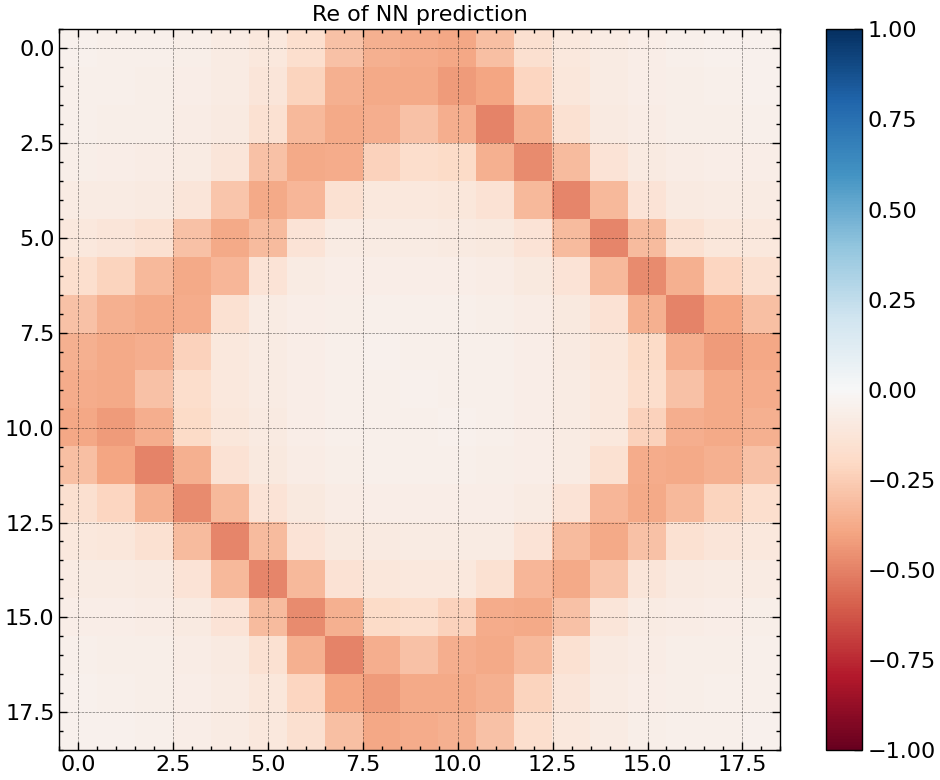

Max diff: 0.09601372480392456
MSE: 0.001344132237136364
(18, 18)


In [9]:
test = get_model_output(1, 1, 1)
print(test.shape)

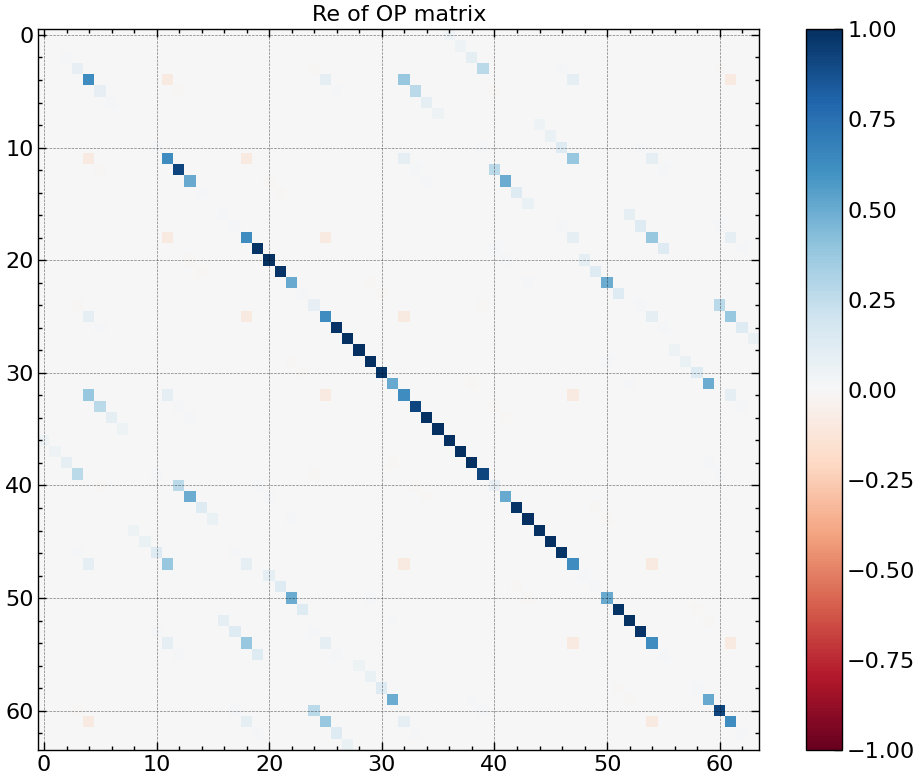

In [14]:
plot_complex_matrix(fold_OP_mat(OP_8x8)[:, :, 0, 0])

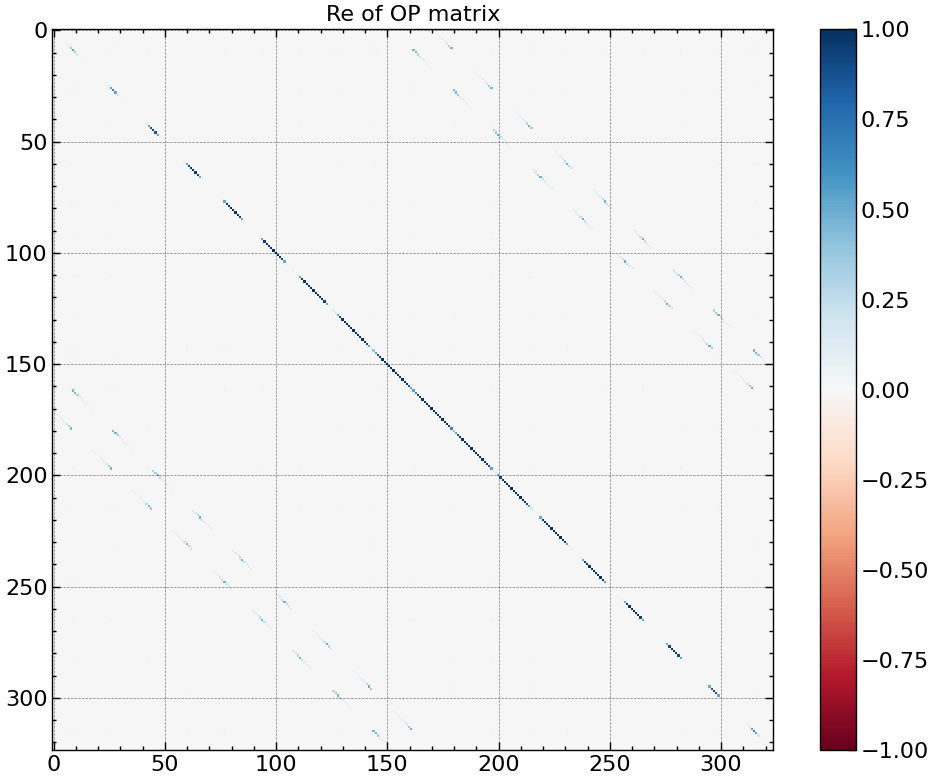

In [13]:
plot_complex_matrix(fold_OP_mat(OP_18x18)[:, :, 0, 0])

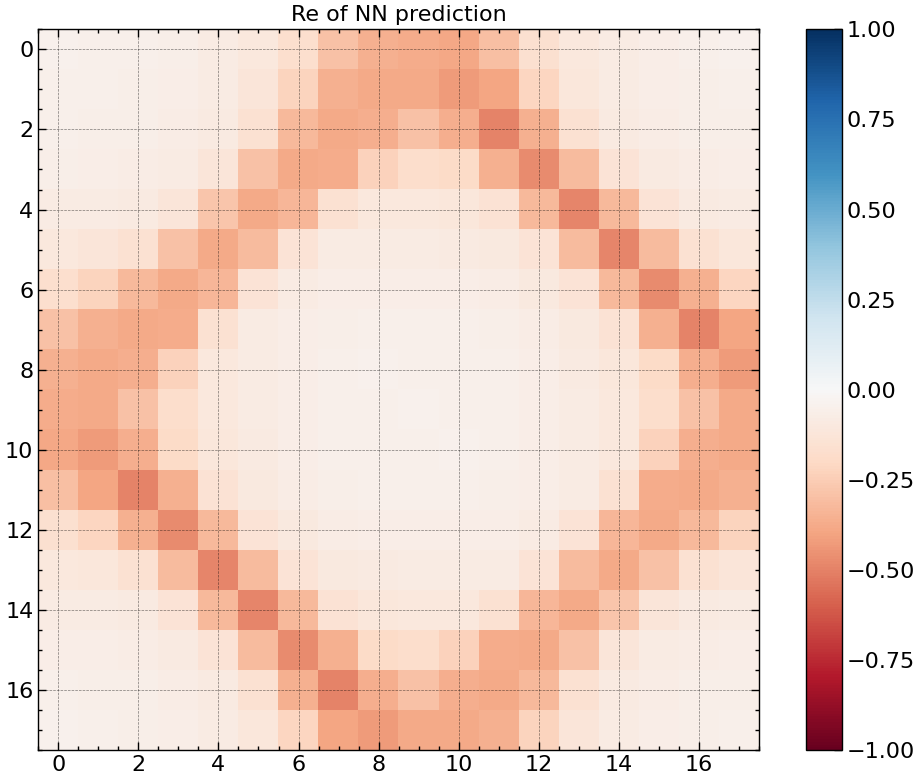

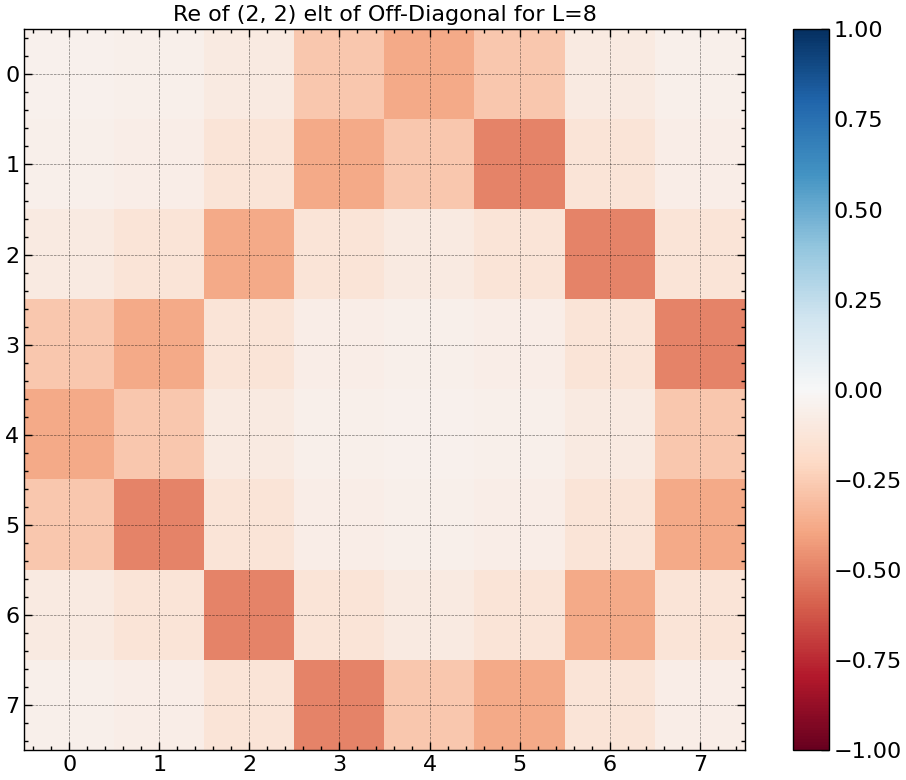

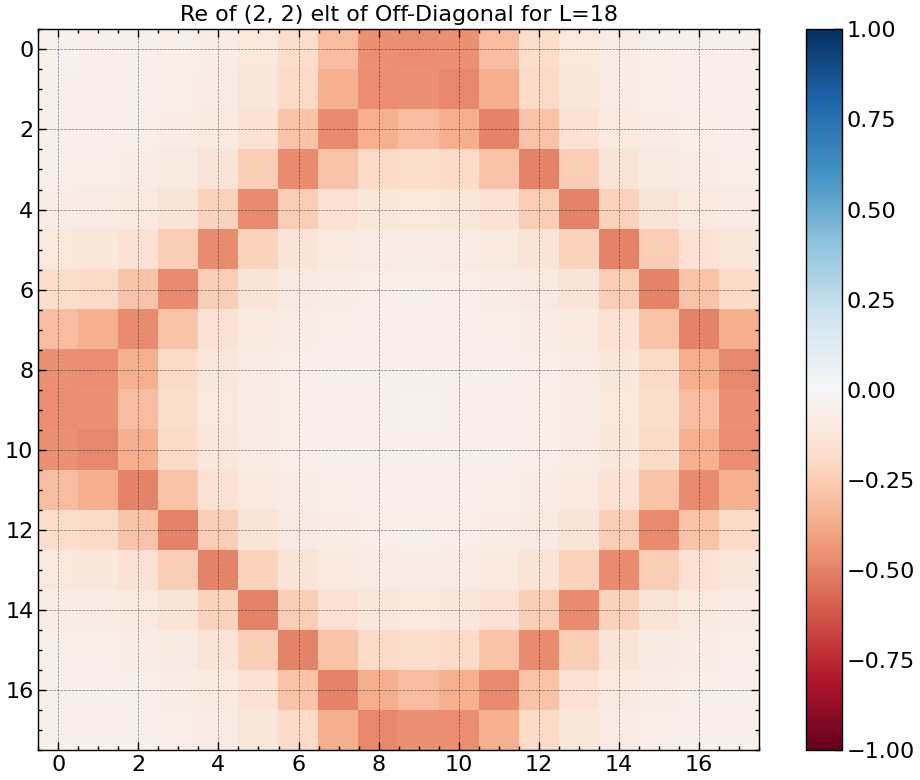

In [11]:
plot_complex_matrix(test, title="NN prediction")
plot_complex_matrix(extract_diagonals(fold_OP_mat(OP_8x8))[1][:, :, 1, 1], title="(2, 2) elt of Off-Diagonal for L=8")
plot_complex_matrix(extract_diagonals(fold_OP_mat(OP_18x18))[1][:, :, 1, 1], title="(2, 2) elt of Off-Diagonal for L=18")

(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : Yes
  reflection_anti_diag     : Yes
Selected mode: adjacent
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : Yes
  reflection_anti_diag     : Yes


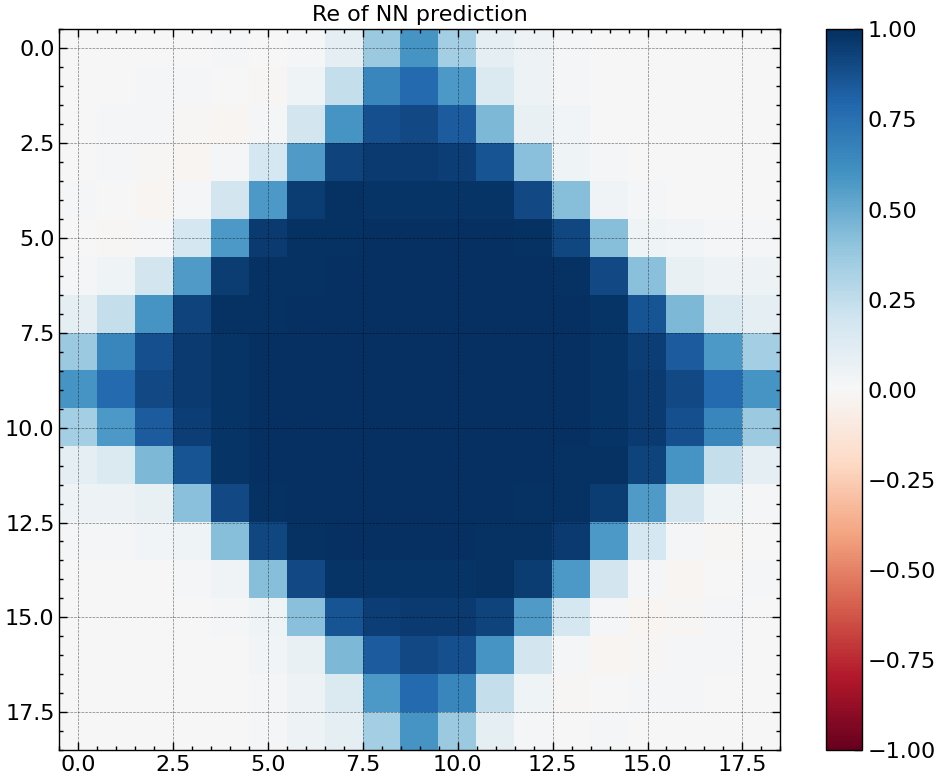

Max diff: 0.11754158139228821
MSE: 0.0010702662402763963
(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : Yes
  reflection_anti_diag     : Yes
Selected mode: adjacent
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : Yes
  reflection_anti_diag     : Yes


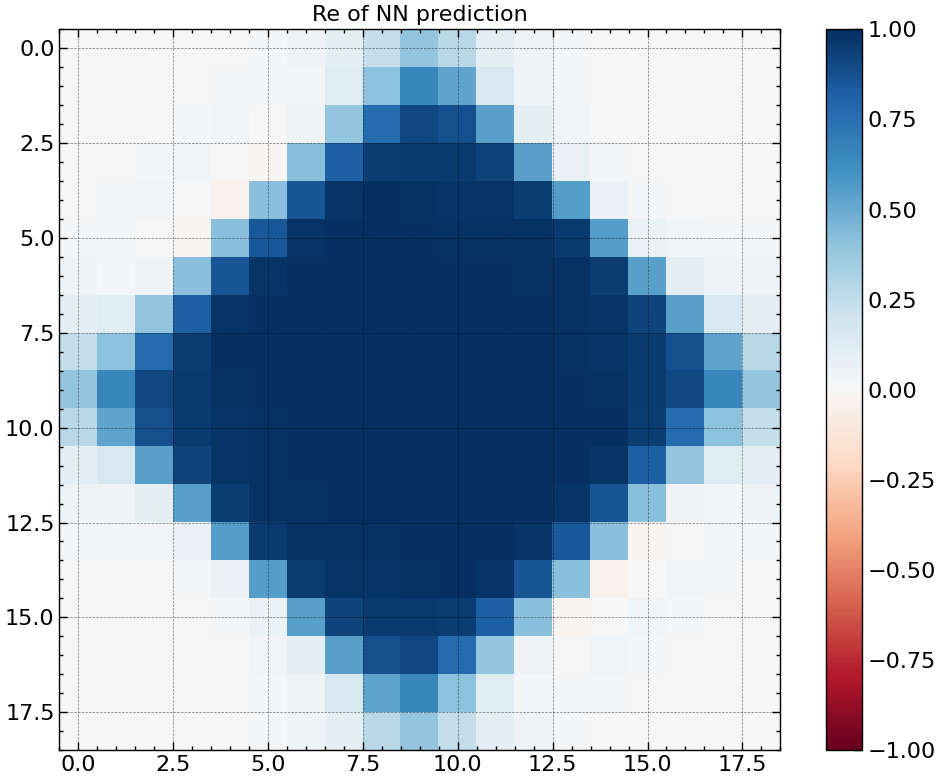

Max diff: 0.0928630530834198
MSE: 0.0009107634541578591
(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : Yes
  reflection_anti_diag     : Yes
Selected mode: adjacent
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : Yes
  reflection_anti_diag     : Yes


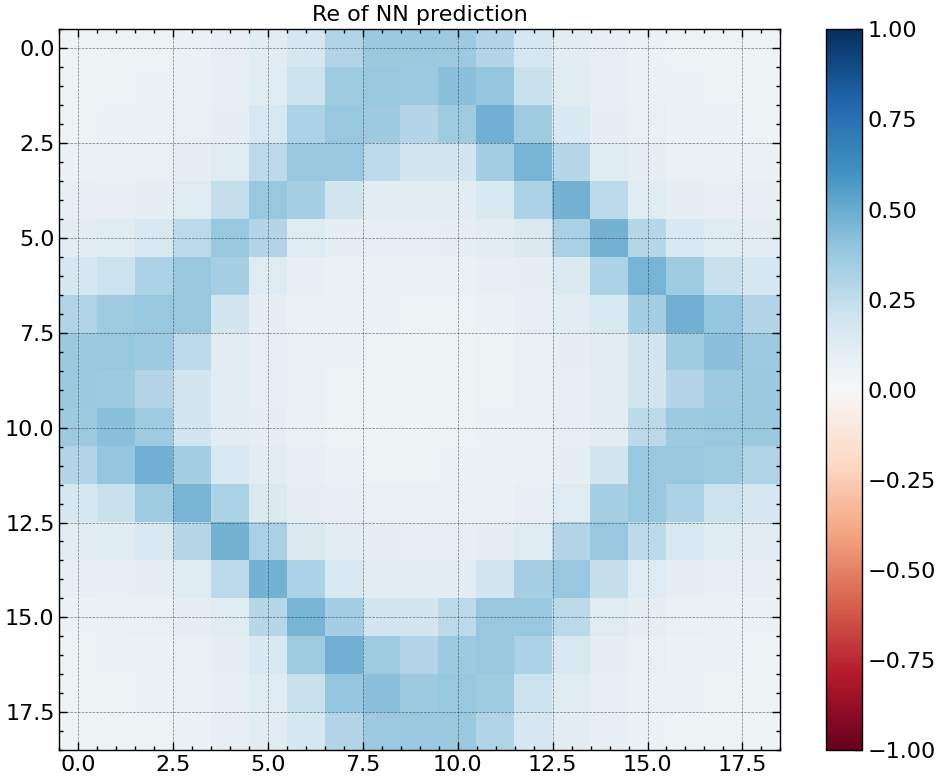

Max diff: 0.0936131477355957
MSE: 0.0013197091175243258
(128, 128)
(648, 648)
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : Yes
  reflection_anti_diag     : Yes
Selected mode: adjacent
D4 Symmetry check results:
  rotation_0               : Yes
  rotation_90              : No
  rotation_180             : Yes
  rotation_270             : No
  reflection_vertical      : No
  reflection_horizontal    : No
  reflection_main_diag     : Yes
  reflection_anti_diag     : Yes


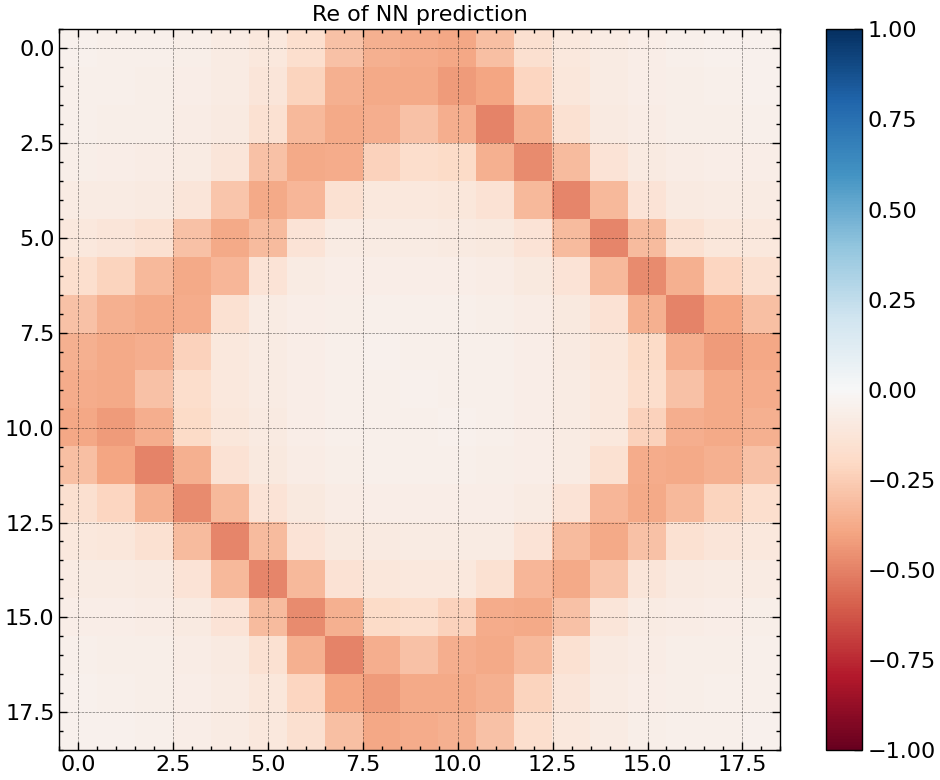

Max diff: 0.09601372480392456
MSE: 0.001344132237136364
(324, 324, 2, 2)


In [56]:
diag_list = []
for diag_idx in (0, 1):
    diag_tensor = np.zeros((18, 18, 2, 2))
    for alpha in (0, 1):
        diag_tensor[:, :, alpha, alpha] = get_model_output(diag_idx, alpha, alpha)
    diag_list.append(diag_tensor)
folded_OP_mat = reformat_matrix_from_diagonals(diag_list)
print(folded_OP_mat.shape)

In [57]:
test_OP = unfold_OP_mat(folded_OP_mat)
print_comparison(OP_18x18, test_OP)

Max diff: 0.11754158439457568
MSE: 8.407327892990675e-06


(np.float64(0.11754158439457568), np.float64(8.407327892990675e-06))

In [58]:
# transpose to get it back in Julia format
OP_results = np.transpose(test_OP)
# separate into real and imaginary parts
OP_results = np.array([OP_results.real, OP_results.imag])
print(OP_results.shape)

(2, 648, 648)


In [59]:
with h5py.File(
    "/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/SIREN_U_1_excited_state/SIREN_18x18_U_1_excited_state.h5", "w"
) as f:
    f.create_dataset("ML_1", data=OP_results)

In [60]:
# test to make sure everything was loaded correctly
with h5py.File(
    "/blue/yujiabin/awwab.azam/hartree-fock-code/src/jobs/SIREN_U_1_excited_state/SIREN_18x18_U_1_excited_state.h5", "r"
) as f:
    check_18x18 = np.transpose(f["ML_1"][()])
    check_18x18 = check_18x18[:, :, 0] + (1j * check_18x18[:, :, 1])

print(check_18x18.shape)
print(check_18x18.dtype)

(648, 648)
complex128


In [61]:
print_comparison(OP_18x18, check_18x18)

Max diff: 0.11754158439457568
MSE: 8.407327892990675e-06


(np.float64(0.11754158439457568), np.float64(8.407327892990675e-06))

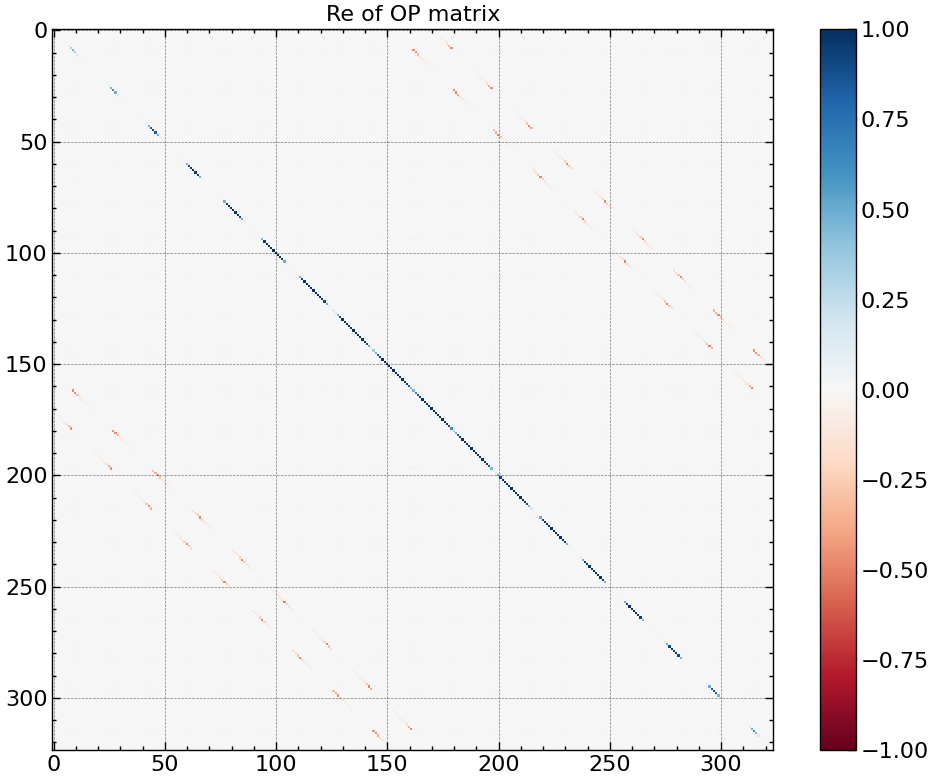

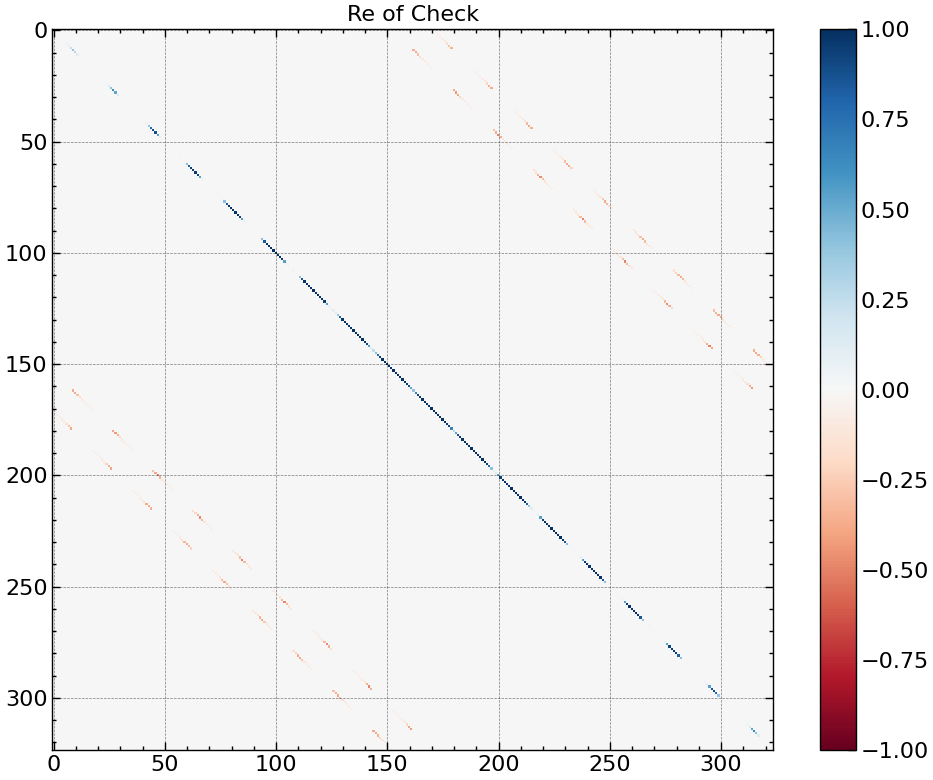

In [62]:
plot_complex_matrix(fold_OP_mat(OP_18x18)[:, :, 1, 1])
plot_complex_matrix(fold_OP_mat(check_18x18)[:, :, 1, 1], title="Check")